In [42]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from pathlib import Path
from torchvision.models import vgg16_bn

In [43]:
path = Path('/home/ec2-user/SageMaker/video_upscaling')
path_data = path/'data'/'DIV2K_train_HR'
path_lr = path/'data'/'lr'
path_mr = path/'data'/'mr'

In [44]:
il = (ImageList.from_folder(path_data)
     #       .use_partial_data(sample_pct=.05, seed=42)
     )

In [45]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_data)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    img = PIL.Image.open(fn)
    targ_size = resize_to(img, size, use_min=True)
    img = img.resize(targ_size, resample=PIL.Image.BILINEAR).convert('RGB')
    
    img.save(dest, quality=60)

In [46]:
sets = [(path_lr, 96), (path_mr, 256)]

for p, size in sets:
    if not p.exists():
        parallel(partial(resize_one, path=p, size=size), il.items)

In [47]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [48]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_data/x.name)
               .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    data.c = 3
    return data

In [49]:
data = get_data(bs, size)

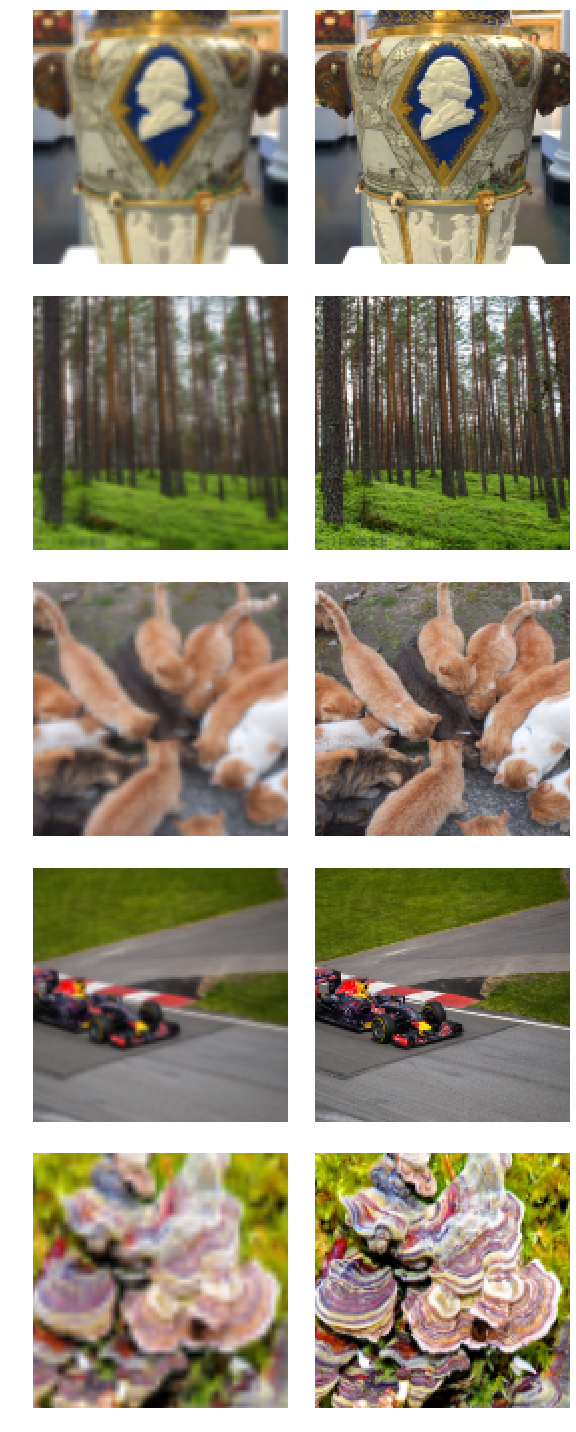

In [9]:
data.show_batch()

## Feature loss

In [10]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [11]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
base_loss = F.l1_loss

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [14]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [15]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [17]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [18]:
#learn.lr_find()
#learn.recorder.plot()

In [19]:
lr = 1e-3

In [20]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

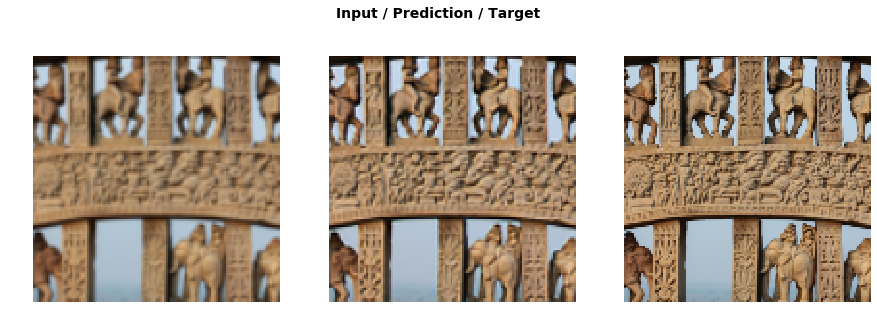

In [21]:
do_fit('1a', slice(lr*10))

In [22]:
learn.unfreeze()

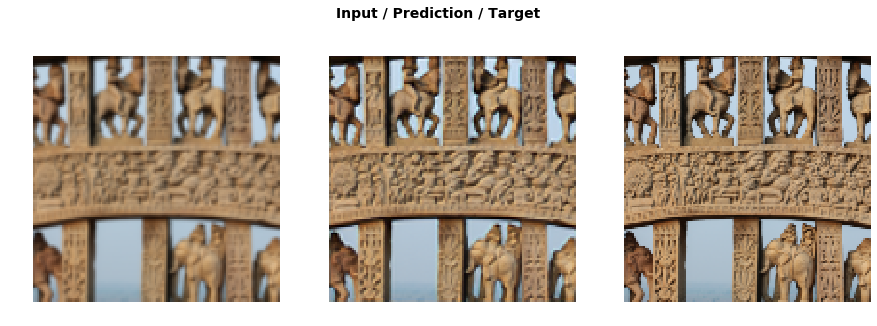

In [23]:
do_fit('1b', slice(1e-5,lr))

In [24]:
data = get_data(12,size*2)

In [25]:
learn.data = data
learn.freeze()
gc.collect()

12069

In [26]:
learn.load('1b');

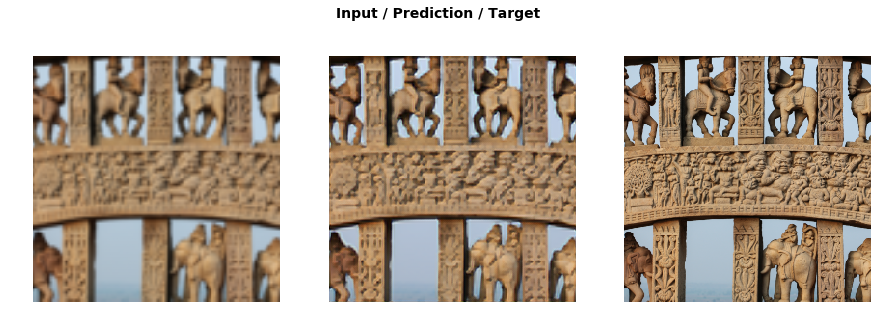

In [ ]:
do_fit('2a')

In [ ]:
learn.unfreeze()

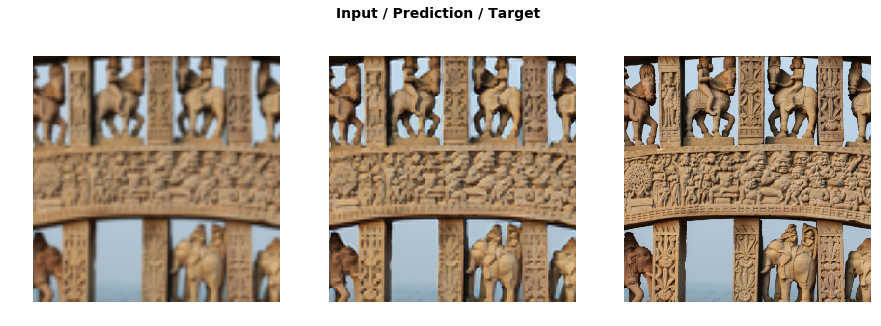

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [62]:
learn = None
gc.collect();

In [63]:
size = (820, 1024)

In [64]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [65]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_data/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [74]:
learn.load('2b');

In [75]:
learn.data = data_mr

In [81]:
fn = data_lr.valid_ds.x.items[0]; fn

PosixPath('/home/ec2-user/SageMaker/video_upscaling/data/mr/0482.png')

In [82]:
img = open_image(fn); img.shape

torch.Size([3, 256, 350])

In [83]:
p,img_hr,b = learn.predict(img)

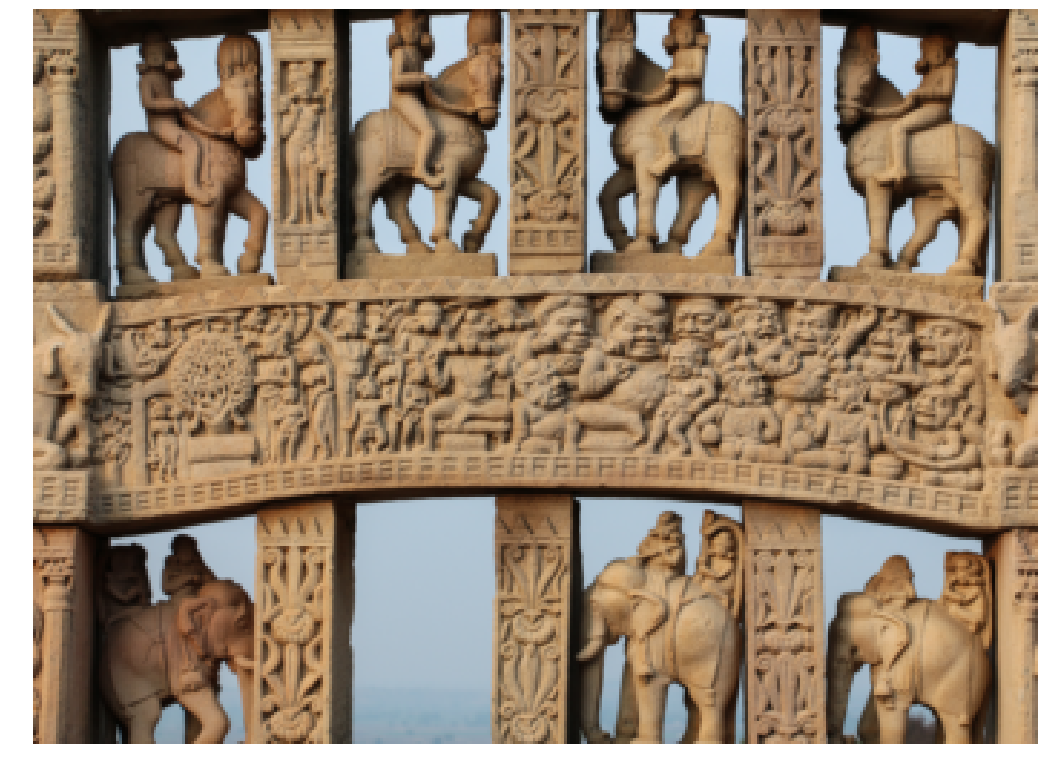

In [84]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


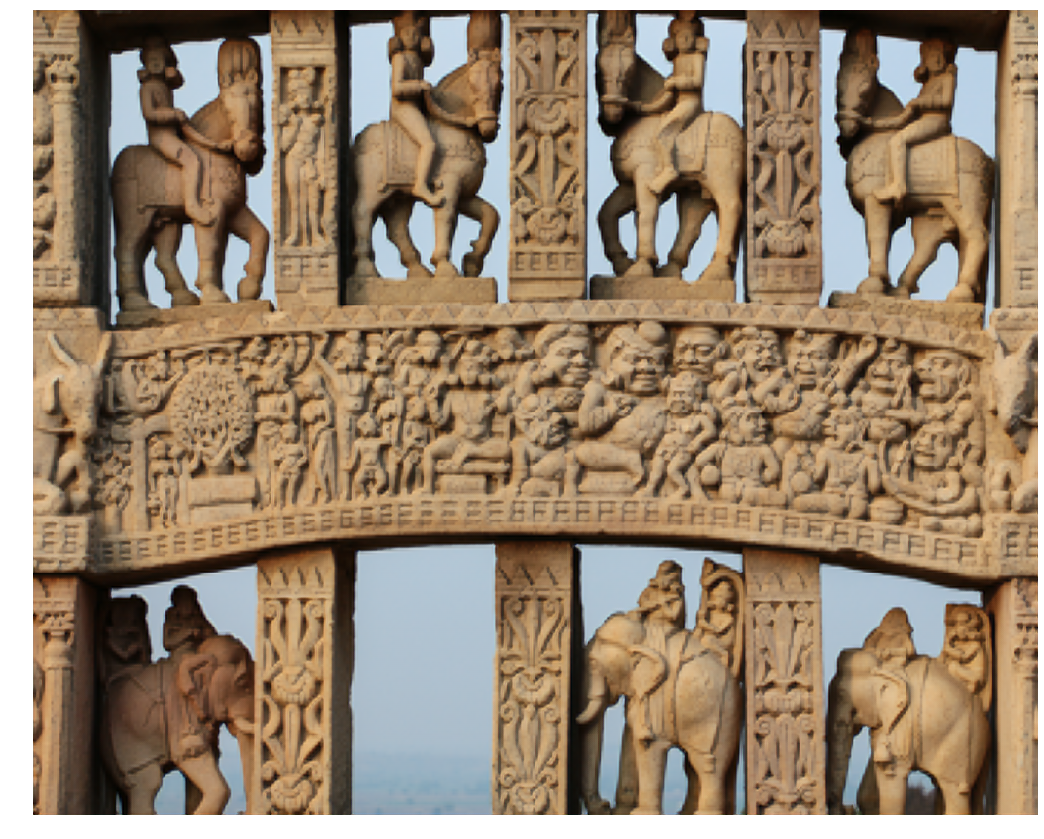

In [85]:
Image(img_hr).show(figsize=(18,15))

In [86]:
img_hr.size()

torch.Size([3, 820, 1024])